#STARRAG FINAL PROJECT



## Background

The rise in the complexity of manufacturing machines calls for deeper monitoring. The growing field is flooded with competitors and has ever-growing demand. With the emergence of AI, it is crucial to leverage such tools to optimize the manufacturing machines to get ahead of the competition. Smart manufacturing and IoT integration were thus born to meet the increasing customer demands and expectations. Maijker Corp focuses on the research, development, and implementation of artificial intelligence technology to be leveraged in the manufacturing landscape. They seek to commercialize research in AI and sensor technology while supporting predictive maintenance by using neural networks to detect patterns and predict impending failures. This allows for preventative mitigation and thus reduces downtime. TAMS in collaboration with Maijker, seeks to implement monitoring technology and proper MTConnect integration.

## Project Description and Scope

In order to optimize the manufacturing process and reduce downtime, AI can be leveraged for smart and continuous monitoring via IoT. This project tackles the problem of developing an AI-based monitoring system to ensure the efficient operation of the Starrag LX21 machine. By training an autoencoder on collected data, the model will learn to encode the key features and characteristics of the machine's behavior. By enriching this autoencoder, the model will be able to detect subtle changes or anomalies in the machine's behavior, potentially enabling early detection of issues or predictive maintenance capabilities. Overall, the project represents a cutting-edge approach to machine monitoring and optimization. Privacy concerns include recording audio in a private environment, but unwanted sound data can easily get filtered out and ignored. Furthermore, the database can be developed in such a way that the sound data is not easily accessible to protect the audio.


## Current Approach

Our current approach, in summary, involves leveraging a preprocessing file to configure the data such that it can be read in by the autoencoder model. The autoencoder will be trained on a .wav file provided to us. Once anomaly thresholds are set, the model will continously be refined to reduce reconstruction error. The model will then be tested for accuracy and functionality.

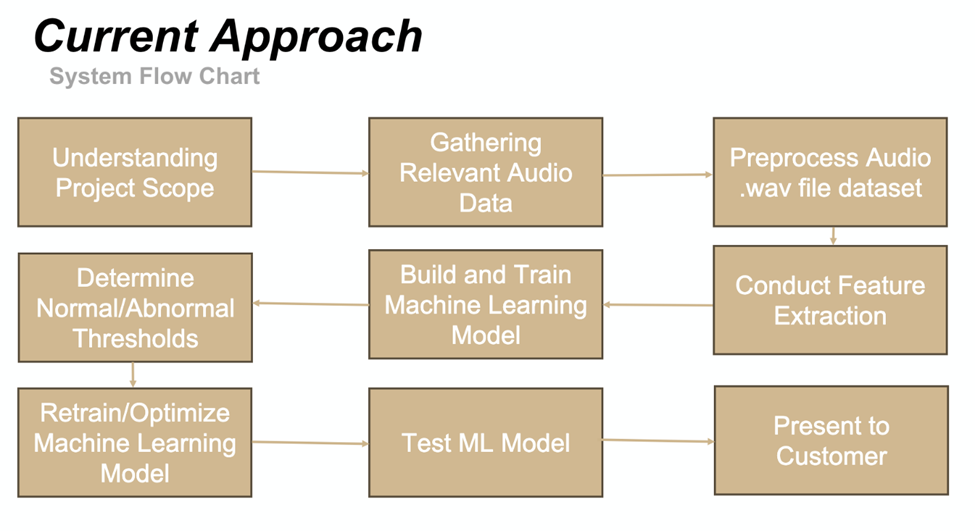

## Components of the Project Solution

Our solution involves an autoencoder model that will read in a 30-second warmup cycle .wav file that is to be recorded from a Maijker Sound Sensor placed in the machine. Through an MTConnect interface the data can be transferred from the LX21 to a computer with this autoencoder model. Time domain plot are generated to have an image of the audio file before it goes through the autoencoder for comparison. After gathering the time domain of the audio files we establish the input pipeline by creating a function that allows us to make the training dataset for the convolutional autoencoder model. Finally, we split the dataset into training and testing data before the autoencoder model. We are using an autoencoder model that has an encoder, latent space, and decoder. We are using the mean absolute error as our loss function and our metric to determine the reconstruction error of our “reconstructed” audio file. The autoencoder has been trained on data and various metrics of its performance can be represented visually throughout this report.


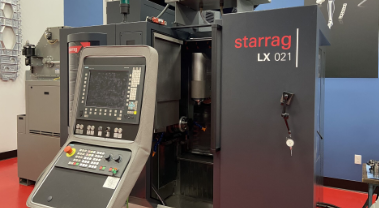

## Step by Step Procedure of Solution Installation

The following procedure can be leveraged to implement the solution. Due to security issues in the Starrag server and difficulties in accessing live data, implementation of this solution may lead to difficulties. The solution can either be configured with the pretrained model or a new model that the user can train themselves. The general procedure is as follows:
1.   Obtain Google Drive Access
2.   Find the audio data on the Maijker cloud database
3.   Obtain a .CSV file detailing the start and end times of each cycle to retrieve proper audio chunks from the Maijker cloud
4.   Upload the .CSV and the proprietary Maijker python library to a Google Drive folder. Update the STORAGE variable to reflect this file path.
5.   Adjust and refine the testing dataset to meet customer needs.


In order to train a new model:
6.   Run the complete code without running the Final Product.
7.   Download the .CSV file that includes the file name and normal vs. abnormal data.


To use the preexisting model:
6.   Run the complete code upto and inlcuding the MAC address code block
7.   Uncomment the first code block of the "Creating Testing Dataset" section - this allows you to load the preexisting .h5 model file with predetermined weights.
8.   Run the remaining code
9.   Download the .CSV file that includes the file name and normal vs. abnormal data.

Though this procedure has only been tailored to work with data from the Maijker cloud database, it can be tweaked to become generalized and scaled to work with other databases in the future.

## Code

The following code provides sample inputs to simulate live data being produced from the Maijker cloud. Sample outputs and test cases are also leveraged. The Calibration/Testing dataset represents be the normal data to be pulled from the cloud database and the data with artifical noise added represents the abnormal data to be the data pulled from cloud.

### Setup and Retrieval of Audio Files

A Google Drive is mounted to earn access to the Maijker library and a .CSV file to be used to pull data from the Maijker Cloud Database.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Local directories are created on Google Colab to separate the data and to store for future use.

In [ ]:
!mkdir ./original_audio
!mkdir ./original_audio/20220818
!mkdir ./preprocessing
!mkdir ./preprocessing/20220818
!mkdir ./reconstructed_audio
!mkdir ./reconstructed_audio/20220818
!mkdir ./testing
!mkdir ./testing/20220818
!mkdir ./postprocessing
!mkdir ./postprocessing/20220818
!mkdir ./reconstructed_audio_gl
!mkdir ./reconstructed_audio_gl/20220818
!mkdir ./abnormal_data
!mkdir ./abnormal_data/20220818

mkdir: cannot create directory ‘./original_audio’: File exists
mkdir: cannot create directory ‘./original_audio/20220818’: File exists
mkdir: cannot create directory ‘./preprocessing’: File exists
mkdir: cannot create directory ‘./preprocessing/20220818’: File exists
mkdir: cannot create directory ‘./reconstructed_audio’: File exists
mkdir: cannot create directory ‘./reconstructed_audio/20220818’: File exists
mkdir: cannot create directory ‘./testing’: File exists
mkdir: cannot create directory ‘./testing/20220818’: File exists
mkdir: cannot create directory ‘./postprocessing’: File exists
mkdir: cannot create directory ‘./postprocessing/20220818’: File exists
mkdir: cannot create directory ‘./reconstructed_audio_gl’: File exists
mkdir: cannot create directory ‘./reconstructed_audio_gl/20220818’: File exists
mkdir: cannot create directory ‘./abnormal_data’: File exists
mkdir: cannot create directory ‘./abnormal_data/20220818’: File exists


Necessary libraries are installed to capitalize on functions such as gathering data from a cloud server or reading/writing audio files.

In [ ]:
!pip install pydub
!pip install azure-storage-file-datalake
!pip install soundfile

Necessary libraries are installed and imported:

In [ ]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sb
import scipy.stats       as sp
import tensorflow        as tf
from tensorflow                 import keras
from keras.models    import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from joblib import dump, load
#from pytictoc import TicToc
from sklearn.manifold      import TSNE
import time
from sklearn.decomposition import KernelPCA
import joblib
import librosa
import datetime
from datetime import timedelta
import os, sys
import shutil
import pickle

This STORAGE variable retains the file path to access the Starrag_LX21, Maijker library, and the parsing .CSV file. This needs to be updated for each user running the code as every file directory varies.

In [ ]:
STORAGE = './drive/MyDrive/PURDUE/Senior Year/Senior Design/starrag_lx21/'

Proprietary Maijker python library is imported.

In [ ]:
# Append the directory to your python path using sys
sys.path.append(STORAGE[:-1])
import maijker

from maijker.services.plotters.historian.cloud import CloudSignalPlotter
from maijker.services.plotters.historian.cloud import CloudStatisticsPlotter
from maijker.services.cloud.api.retriever import MaijkerCloudRetriever
from maijker.services.machinelearning.preprocessors.audio.preprocessor import Rolling_Window_Audio_Preprocessor
from maijker.services.machinelearning.modelbuilders.audio.nn.autoencoder import Convolutional_AutoEncoder_Builder

An accurate MAC address is required to gain access to the Starrage Showroom. It directly links to the specific sound sensor being used on the LX21 for gathering sound data. This MAC address can link directly to this sound data via the data lake.

In [ ]:
SENSOR_MAC = 'E4:5F:01:78:5E:7F' # Starrag Showroom - LX

audio_file_storage = './original_audio/20220818'
preprocessing_storage = './preprocessing/20220818'
cycle_csv = STORAGE + 'warmup_cycles_20220818.csv'

This block reads the .CSV file and creates 50 audio samples (each of length 28-29 seconds) and saves it to the audio_file_storage location. Due to resource and time constraints only 50 samples were created of the 1772 samples possible.

In [ ]:
cycle_dataframe = pd.read_csv(cycle_csv)
dataframe_shape = cycle_dataframe.shape

file_array = [None] * dataframe_shape[0]
cntr = 0
for index in cycle_dataframe.index:
    print('Cycle: ' + str(cntr + 1) +  ' of ' + str(dataframe_shape[0]))
    start = cycle_dataframe['StartLocal'][index]
    end = cycle_dataframe['EndLocal'][index]
    print(end)
    retriever = MaijkerCloudRetriever(SENSOR_MAC)
    sound_file_name = retriever.get_datalake_wav_file(start, end)
    print(sound_file_name)
    new_path = audio_file_storage + '/' + sound_file_name[2:]
    file_array[cntr] = sound_file_name
    os.rename(sound_file_name[2:], new_path)
    cntr = cntr + 1
    print('\n')
    if cntr >= 50:
      break

cycle_dataframe['FileName'] = file_array
save_file = '20220818_warmup_cycle_files_august.csv'
cycle_dataframe.to_csv(save_file, encoding='utf-8')

Cycle: 1 of 1772
8/18/2022 18:09:49
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A09%3A20%2B00%3A00&EndUtc=2022-08-18%2018%3A09%3A49%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


Clip and Merge: 3 Audio Files
./934325fe-d52d-4d4b-9a2a-145bda6f277f.wav


Cycle: 2 of 1772
8/18/2022 18:10:19
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A09%3A49%2B00%3A00&EndUtc=2022-08-18%2018%3A10%3A19%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Clip and Merge: 4 Audio Files
./f14c566d-4fda-4bb4-850e-250fae0f75d4.wav


Cycle: 3 of 1772
8/18/2022 18:10:47
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A10%3A19%2B00%3A00&EndUtc=2022-08-18%2018%3A10%3A47%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Clip and Merge: 4 Audio Files
./e0a82d4e-7d59-4866-b4f1-8d0711313438.wav


Cycle: 4 of 1772
8/18/2022 18:11:15
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A10%3A47%2B00%3A00&EndUtc=2022-08-18%2018%3A11%3A15%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Clip and Merge: 4 Audio Files
./92895ba3-5641-46b7-b638-9bd32052014e.wav


Cycle: 5 of 1772
8/18/2022 18:11:44
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A11%3A15%2B00%3A00&EndUtc=2022-08-18%2018%3A11%3A44%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Clip and Merge: 4 Audio Files
./7d13ea25-e568-4ef8-8f1c-3e7bd44dafb5.wav


Cycle: 6 of 1772
8/18/2022 18:12:12
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A11%3A44%2B00%3A00&EndUtc=2022-08-18%2018%3A12%3A12%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


Clip and Merge: 3 Audio Files
./a8df4d1f-c02b-4b00-b518-32acc95fd2e0.wav


Cycle: 7 of 1772
8/18/2022 18:12:41
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A12%3A12%2B00%3A00&EndUtc=2022-08-18%2018%3A12%3A41%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Clip and Merge: 4 Audio Files
./ef5652d2-f1b0-43de-a62b-2b6dd5ea1e5d.wav


Cycle: 8 of 1772
8/18/2022 18:13:09
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A12%3A41%2B00%3A00&EndUtc=2022-08-18%2018%3A13%3A09%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Clip and Merge: 4 Audio Files
./620067dd-65bf-46cf-8d0b-47f53d000362.wav


Cycle: 9 of 1772
8/18/2022 18:13:37
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A13%3A09%2B00%3A00&EndUtc=2022-08-18%2018%3A13%3A37%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


Clip and Merge: 4 Audio Files
./7e52c82c-3d96-41b5-bdaf-b0f3e5042450.wav


Cycle: 10 of 1772
8/18/2022 18:14:06
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A13%3A37%2B00%3A00&EndUtc=2022-08-18%2018%3A14%3A06%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Clip and Merge: 4 Audio Files
./d3d83f8b-290c-48b0-89c3-1caf49c53607.wav


Cycle: 11 of 1772
8/18/2022 18:14:34
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A14%3A06%2B00%3A00&EndUtc=2022-08-18%2018%3A14%3A34%2B00%3A00


100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Clip and Merge: 3 Audio Files
./d3a51cdc-c132-4fd1-8619-8c65025b4090.wav


Cycle: 12 of 1772
8/18/2022 18:15:03
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A14%3A34%2B00%3A00&EndUtc=2022-08-18%2018%3A15%3A03%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Clip and Merge: 4 Audio Files
./9d2b2c79-859b-4212-adbd-318d27c1666f.wav


Cycle: 13 of 1772
8/18/2022 18:15:31
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A15%3A03%2B00%3A00&EndUtc=2022-08-18%2018%3A15%3A31%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Clip and Merge: 4 Audio Files
./c919785c-e20a-4eec-ab45-3e36c2260439.wav


Cycle: 14 of 1772
8/18/2022 18:16:00
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A15%3A31%2B00%3A00&EndUtc=2022-08-18%2018%3A16%3A00%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Clip and Merge: 4 Audio Files
./0900f01c-354f-4ef6-b4eb-aa0db0a5a3e3.wav


Cycle: 15 of 1772
8/18/2022 18:16:28
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A16%3A00%2B00%3A00&EndUtc=2022-08-18%2018%3A16%3A28%2B00%3A00


100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


Clip and Merge: 3 Audio Files
./1624f183-031b-42c0-bf55-82ff3aacc234.wav


Cycle: 16 of 1772
8/18/2022 18:16:56
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A16%3A28%2B00%3A00&EndUtc=2022-08-18%2018%3A16%3A56%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


Clip and Merge: 4 Audio Files
./3fabc4af-d3ae-4b44-8b44-1bf31722159a.wav


Cycle: 17 of 1772
8/18/2022 18:17:25
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A16%3A56%2B00%3A00&EndUtc=2022-08-18%2018%3A17%3A25%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


Clip and Merge: 4 Audio Files
./a9d9fabb-b48a-4d19-8ded-e0e6b71a773b.wav


Cycle: 18 of 1772
8/18/2022 18:17:53
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A17%3A25%2B00%3A00&EndUtc=2022-08-18%2018%3A17%3A53%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Clip and Merge: 4 Audio Files
./beade1a8-04e4-4397-b1ff-f3d1ee8bb713.wav


Cycle: 19 of 1772
8/18/2022 18:18:22
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A17%3A53%2B00%3A00&EndUtc=2022-08-18%2018%3A18%3A22%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Clip and Merge: 4 Audio Files
./66dc1d7f-5241-4ff9-98f1-d8cf520822f4.wav


Cycle: 20 of 1772
8/18/2022 18:18:50
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A18%3A22%2B00%3A00&EndUtc=2022-08-18%2018%3A18%3A50%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Clip and Merge: 3 Audio Files
./b07a7d16-4d48-4c5a-8985-117114459d40.wav


Cycle: 21 of 1772
8/18/2022 18:19:19
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A18%3A50%2B00%3A00&EndUtc=2022-08-18%2018%3A19%3A19%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Clip and Merge: 4 Audio Files
./d327d991-f70b-4bbc-af40-96bb177ae86e.wav


Cycle: 22 of 1772
8/18/2022 18:19:47
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A19%3A19%2B00%3A00&EndUtc=2022-08-18%2018%3A19%3A47%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Clip and Merge: 4 Audio Files
./baa13247-5c26-4913-861b-e45bd646d552.wav


Cycle: 23 of 1772
8/18/2022 18:20:16
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A19%3A47%2B00%3A00&EndUtc=2022-08-18%2018%3A20%3A16%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Clip and Merge: 4 Audio Files
./902b5207-aacd-43a3-b2eb-ccf30d0baa5c.wav


Cycle: 24 of 1772
8/18/2022 18:20:44
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A20%3A16%2B00%3A00&EndUtc=2022-08-18%2018%3A20%3A44%2B00%3A00


100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


Clip and Merge: 3 Audio Files
./af365b15-0acb-45f2-bdb2-402b9df418f5.wav


Cycle: 25 of 1772
8/18/2022 18:21:12
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A20%3A44%2B00%3A00&EndUtc=2022-08-18%2018%3A21%3A12%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Clip and Merge: 4 Audio Files
./f50a1264-32f1-4e84-bfa7-cdd9126c80d4.wav


Cycle: 26 of 1772
8/18/2022 18:21:41
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A21%3A12%2B00%3A00&EndUtc=2022-08-18%2018%3A21%3A41%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


Clip and Merge: 4 Audio Files
./1d401f4b-7ccb-42b9-afcd-37fa6835d0e9.wav


Cycle: 27 of 1772
8/18/2022 18:22:10
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A21%3A41%2B00%3A00&EndUtc=2022-08-18%2018%3A22%3A10%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Clip and Merge: 4 Audio Files
./8eac7a59-1a13-4794-b853-2f1b989117b0.wav


Cycle: 28 of 1772
8/18/2022 18:22:38
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A22%3A10%2B00%3A00&EndUtc=2022-08-18%2018%3A22%3A38%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Clip and Merge: 4 Audio Files
./20e0cbe5-0cdb-4909-bd48-7dccc74ea373.wav


Cycle: 29 of 1772
8/18/2022 18:23:06
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A22%3A38%2B00%3A00&EndUtc=2022-08-18%2018%3A23%3A06%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


Clip and Merge: 3 Audio Files
./09e1c977-25f7-4c45-860c-0d6290ddb6e1.wav


Cycle: 30 of 1772
8/18/2022 18:23:35
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A23%3A06%2B00%3A00&EndUtc=2022-08-18%2018%3A23%3A35%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Clip and Merge: 4 Audio Files
./7551ee8e-5fc0-43c4-8284-43ac2292d033.wav


Cycle: 31 of 1772
8/18/2022 18:24:03
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A23%3A35%2B00%3A00&EndUtc=2022-08-18%2018%3A24%3A03%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Clip and Merge: 4 Audio Files
./7ae6ca16-ceea-4c90-8a9e-551ba8528ba6.wav


Cycle: 32 of 1772
8/18/2022 18:24:32
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A24%3A03%2B00%3A00&EndUtc=2022-08-18%2018%3A24%3A32%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Clip and Merge: 4 Audio Files
./dee6d385-5c38-4e2e-840e-767d3390214b.wav


Cycle: 33 of 1772
8/18/2022 18:25:00
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A24%3A32%2B00%3A00&EndUtc=2022-08-18%2018%3A25%3A00%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


Clip and Merge: 3 Audio Files
./bbaaf4d1-e6e4-4cdb-85f0-5e4be710b9af.wav


Cycle: 34 of 1772
8/18/2022 18:25:29
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A25%3A00%2B00%3A00&EndUtc=2022-08-18%2018%3A25%3A29%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Clip and Merge: 4 Audio Files
./2613d8e7-9b40-405a-ad1c-94f96c76188d.wav


Cycle: 35 of 1772
8/18/2022 18:25:57
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A25%3A29%2B00%3A00&EndUtc=2022-08-18%2018%3A25%3A57%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Clip and Merge: 4 Audio Files
./2c2834d8-e82c-4148-9c46-5500051b1cbe.wav


Cycle: 36 of 1772
8/18/2022 18:26:25
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A25%3A57%2B00%3A00&EndUtc=2022-08-18%2018%3A26%3A25%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Clip and Merge: 4 Audio Files
./bcf6c654-6916-4411-bf1f-af3d6ecc73a3.wav


Cycle: 37 of 1772
8/18/2022 18:26:54
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A26%3A25%2B00%3A00&EndUtc=2022-08-18%2018%3A26%3A54%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Clip and Merge: 4 Audio Files
./c3a89fb5-3104-4f48-9d79-08a9271ce934.wav


Cycle: 38 of 1772
8/18/2022 18:27:22
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A26%3A54%2B00%3A00&EndUtc=2022-08-18%2018%3A27%3A22%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


Clip and Merge: 3 Audio Files
./95d73948-a388-4a5a-bdd3-758b457db6ee.wav


Cycle: 39 of 1772
8/18/2022 18:27:50
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A27%3A22%2B00%3A00&EndUtc=2022-08-18%2018%3A27%3A50%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Clip and Merge: 4 Audio Files
./8a4a5806-29dd-4e01-b344-bee7f2e07998.wav


Cycle: 40 of 1772
8/18/2022 18:28:19
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A27%3A50%2B00%3A00&EndUtc=2022-08-18%2018%3A28%3A19%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Clip and Merge: 4 Audio Files
./a66551dd-c1dc-4735-91ce-c43fb7a030c4.wav


Cycle: 41 of 1772
8/18/2022 18:28:47
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A28%3A19%2B00%3A00&EndUtc=2022-08-18%2018%3A28%3A47%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Clip and Merge: 4 Audio Files
./7f083f1e-97ea-4b90-9280-7258e3e5c382.wav


Cycle: 42 of 1772
8/18/2022 18:29:16
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A28%3A47%2B00%3A00&EndUtc=2022-08-18%2018%3A29%3A16%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Clip and Merge: 3 Audio Files
./1b49f453-48dc-4e8c-a3c2-c9cd87da113d.wav


Cycle: 43 of 1772
8/18/2022 18:29:44
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A29%3A16%2B00%3A00&EndUtc=2022-08-18%2018%3A29%3A44%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Clip and Merge: 4 Audio Files
./183aed96-d11c-46b0-8566-1246cfa6741d.wav


Cycle: 44 of 1772
8/18/2022 18:30:13
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A29%3A44%2B00%3A00&EndUtc=2022-08-18%2018%3A30%3A13%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Clip and Merge: 4 Audio Files
./7be7f20e-1a3c-4733-affa-b4364cf39c36.wav


Cycle: 45 of 1772
8/18/2022 18:30:41
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A30%3A13%2B00%3A00&EndUtc=2022-08-18%2018%3A30%3A41%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Clip and Merge: 4 Audio Files
./61c12dcc-16d1-49f6-a117-4c3b0cf50241.wav


Cycle: 46 of 1772
8/18/2022 18:31:10
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A30%3A41%2B00%3A00&EndUtc=2022-08-18%2018%3A31%3A10%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Clip and Merge: 4 Audio Files
./a026735b-75a8-4633-a5d4-2ea3f877fd3b.wav


Cycle: 47 of 1772
8/18/2022 18:31:38
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A31%3A10%2B00%3A00&EndUtc=2022-08-18%2018%3A31%3A38%2B00%3A00


100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Clip and Merge: 3 Audio Files
./9737c0d0-6a28-4078-8195-17aae5cee2a7.wav


Cycle: 48 of 1772
8/18/2022 18:32:07
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A31%3A38%2B00%3A00&EndUtc=2022-08-18%2018%3A32%3A07%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Clip and Merge: 4 Audio Files
./8401bbb8-b43b-4ca2-aca7-b396f5bdec6e.wav


Cycle: 49 of 1772
8/18/2022 18:32:36
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A32%3A07%2B00%3A00&EndUtc=2022-08-18%2018%3A32%3A36%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Clip and Merge: 4 Audio Files
./d0dc9912-a13f-4d54-8f5a-a06ad2635aaf.wav


Cycle: 50 of 1772
8/18/2022 18:33:03
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A32%3A36%2B00%3A00&EndUtc=2022-08-18%2018%3A33%3A03%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

Clip and Merge: 4 Audio Files
./788ecd18-ccc3-433c-9a9d-5661027a23c5.wav




### Processing Pipline
Using the librosa library, the audio files are uploaded to Google Colab. They get slices to a set duration and get padded to retain the shape of the array. Log spectrograms are extracted from the audio files. Such data is then saved to use as training data for the autoencoder model.

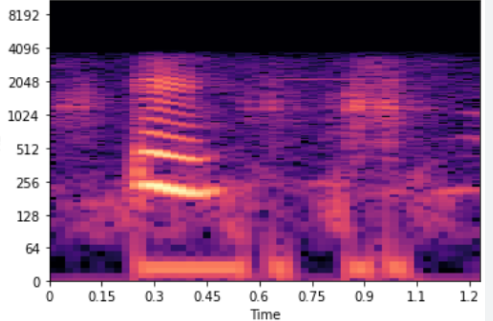


A log spectrogram is a visual representation of the frequency content of a signal over time. It's created by taking the STFT of a signal, breaking the signal into short segments and computing the Fourier Transform for each segment. The STFT signal [X(n,w)] can be found using the original signal [x(m)], where w(m−n) is a window function centered at time index 𝑛 and ω is the frequency.
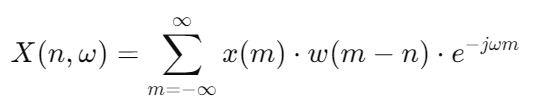

The resulting spectrogram represents the frequency content of the signal at different points in time, with time on the horizontal axis, frequency on the vertical axis (on a logarithmic scale), and intensity of the frequency components represented by color or grayscale. To convert the STFT result into a log scale, the following equation can be leveraged:

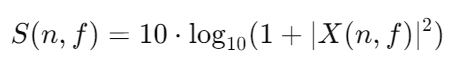

This representation best represents an audio file and contains the most pertinent features needed for a convolutional neural network to process the data. By representing sound similar to the form of an array, it can better be analyzed and leveraged in an ML model.


The following helper functions help streamline this solution. The first function normalizes the data to standardized the range. The second function undoes this. A dictionary function was also created to store min and max values of the audio file. There is also a function to check whether or not an audio file requires padding based on the number of samples. Its output ultimately decides to call whether or not the front/back padding functions should be called. A helper function is also used to save the data to a .PKL file and the last function saves the minimum and maximum values of the .PKL file to a directory.

In [ ]:
#Helper Functions


#Normalization Helper Functions

#Normalizes the dataset, generally to between a 0 and 1 range
def normalize(array, min_val, max_val):
  norm_array = (array - array.min()) / (array.max() - array.min())
  norm_array = norm_array * (max_val - min_val) + min_val
  return norm_array

#Deormalizes the dataset from the specified range to the original audio range
def denormalize(norm_array, min_val, max_val, original_min, original_max):
  array = (norm_array - min_val) / (max_val - min_val)
  array = norm_array * (original_max - original_min) + original_min
  return array

min_max_values = {}

#A dictionary that stores min and max values of each audio file
def store_min_max_values(save_path, min_val, max_val):
  min_max_values[save_path] = {
      "min": min_val,
      "max": max_val
  }

#Padding Helper Functions
padding = False

#Checks if padding is necessary based on the number of expected samples
def padding_bool(signal, sample_rate, duration):
  num_expected_samples = int(sample_rate * duration)
  if len(signal) < num_expected_samples:
    padding = True
  else:
    padding = False
  return padding

#Padding the signal from the start of the array
def left_pad(array, num_items):
  padded_array = np.pad(array, (0, num_items))
  return padded_array

#Padding the signal from the end of the array
def right_pad(array, num_items):
  padded_array = np.pad(array, (num_items, 0))
  return padded_array

#Saver Functions

#Saves the data into a pkl file
def save(data, save_path):
  with open(save_path, "wb") as f:
    pickle.dump(data, f)

#Saves the min max values pkl file to a directory
def save_min_max_values(min_max_values, min_max_save_dir):
  save_path = os.path.join(min_max_save_dir, "min_max_values.pkl")
  save(min_max_values, save_path)


This is the main code for the preprocesing pipline. It loads the audio file, iterates through the files in the audio_file_storage directory, trims or pads the signals, computes the STFT, converts it to a log scale, normalizes it, saves its features as a numpy array, and creates a zip file with min and max values.

To create a log spectrogram, STFT is needed because it decomposes a signal into its frequency components over time in the form of bite sized frames or windows. This allows for specific frequency analysis over each frame and track frequency changes over time. Within this context, frame_size describes the window length and hop_size describes the overlap between the windows. A larger frame size improves frequency resolution at the expense of time resolution. Shorter hop sizes results in more frame overlap, leading to smoother transitions in the spectrogram.

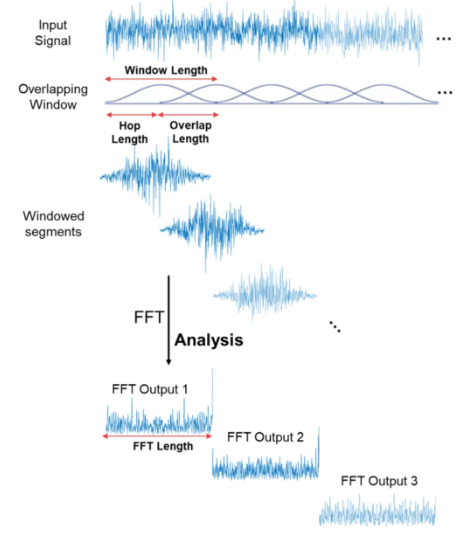

In [ ]:
#PREPROCESSING PIPLINE
audio_file_storage = './original_audio/20220818'
preprocessing_storage = './preprocessing/20220818'

#Necessary parameters
FRAME_SIZE = 2048
HOP_LENGTH = int(FRAME_SIZE / 4)
NUM_SAMPLES = 593500

#Looping through the audio file directory
for root, _, files in os.walk(audio_file_storage):
  for audio_file in files:
    #Loading the file
    file_path = os.path.join(root, audio_file)
    signal = librosa.load(file_path)[0]

    #Cutting the signal into an equal size (~12 seconds)
    signal = signal[:NUM_SAMPLES]
    sample_rate = librosa.get_samplerate(file_path)
    duration = librosa.get_duration(y= signal, sr = sample_rate)

    #Padding the signal if necessary
    padding = padding_bool(signal, sample_rate, duration)
    if padding == True:
      num_expected_samples = int(sample_rate * duration)
      num_missing_samples = num_expected_samples - len(signal)
      padded_signal = right_pad(signal, num_missing_samples)
      signal = padded_signal


    #Extracting the log spectrogram from the audio file
    stft = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_LENGTH)[:-1]
    #print(stft.shape)
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    feature = log_spectrogram
    norm_feature = normalize(feature,0,1)

    #Saving the log spectrogram feature to preprocessing directory
    file_name = os.path.split(file_path)[1]
    save_path = os.path.join(preprocessing_storage, file_name[:-4] + ".npy")
    np.save(save_path, norm_feature)

    #Store min and max values in the dictionary
    store_min_max_values(save_path, feature.min(), feature.max())
    print(f'Processing File: {file_name}')

#Saving the min max values dictionary
min_max_storage = './preprocessing'
save_min_max_values(min_max_values, min_max_storage)

Processing File: 7d13ea25-e568-4ef8-8f1c-3e7bd44dafb5.wav
Processing File: 61c12dcc-16d1-49f6-a117-4c3b0cf50241.wav
Processing File: d3a51cdc-c132-4fd1-8619-8c65025b4090.wav
Processing File: af365b15-0acb-45f2-bdb2-402b9df418f5.wav
Processing File: d327d991-f70b-4bbc-af40-96bb177ae86e.wav
Processing File: 3fabc4af-d3ae-4b44-8b44-1bf31722159a.wav
Processing File: 934325fe-d52d-4d4b-9a2a-145bda6f277f.wav
Processing File: 183aed96-d11c-46b0-8566-1246cfa6741d.wav
Processing File: 902b5207-aacd-43a3-b2eb-ccf30d0baa5c.wav
Processing File: 8eac7a59-1a13-4794-b853-2f1b989117b0.wav
Processing File: a66551dd-c1dc-4735-91ce-c43fb7a030c4.wav
Processing File: beade1a8-04e4-4397-b1ff-f3d1ee8bb713.wav
Processing File: d3d83f8b-290c-48b0-89c3-1caf49c53607.wav
Processing File: 8401bbb8-b43b-4ca2-aca7-b396f5bdec6e.wav
Processing File: 1d401f4b-7ccb-42b9-afcd-37fa6835d0e9.wav
Processing File: a8df4d1f-c02b-4b00-b518-32acc95fd2e0.wav
Processing File: dee6d385-5c38-4e2e-840e-767d3390214b.wav
Processing Fil

A training dataset is created by looping through the preprocessing directory containing all of the specotrgrams and loading it as a numpy array to be used for the autoencoder model. This is then appended to the x_train variable to create the training dataset.

In [ ]:
#Creating the Training Dataset

x_train = []
for root, _, file_names in os.walk(preprocessing_storage):
    for file_name in file_names:
        file_path = os.path.join(root, file_name)
        spectrogram = np.load(file_path) # (n_bins, n_frames)
        #print(spectrogram.shape)
        x_train.append(spectrogram)
x_train = np.array(x_train)

#Adding another axis to make it a 4D array and to showcase the number of channels
x_train = x_train[..., np.newaxis] # -> (n_files, n_bins, n_frames, num_channels)
x_train.shape

(50, 1024, 1160, 1)

###Convolutional Autoencoder Model

The hyperparameters used for the autoencoder model can be seen below. Through significant and repeated preliminary testing, these values were refined to optimize the model results.


The learning rate controls the step size during optimization. A rate too high may speed up convergence but may cause the optimization process to oscillate or diverge.
Epochs determine the number of passes the model will work through the dataset during training. More epochs allows the model to learn but too many can lead to overfitting and not seeing the bigger picture.
Batch size represents the number of training examples used in one iteration. A larger batch size offers more stable updates but requires more memory and may slow down training.
Latent space dimensions represents the low-dimensional space where the model encodes input data in variational autoencoders. Higher-dimensional latent spaces may capture more complex features but can also lead to overfitting, while lower-dimensional spaces may result in simpler representations but may lead to losing critical information.

In [ ]:
#Hyperparameters for the Convolutional Autoencoder

LEARNING_RATE = 0.0005
EPOCHS = 20
BATCH_SIZE = 5

LATENT_SPACE_DIMS = 2


Autoencoders are a special type of feedforward neural network for unsupervised learning tasks, like data compression and reconstruction. The main function of an autoencoder is to compress and replicate the input data to create a more efficient and accurate representation of data. It consists of two fully connected neural networks: the encoder and decoder. The encoder compresses the input data into a latent-space representation, which captures the most important features of the input data due to its lower dimensionality. The latent-space representation is then fed into the decoder which attempts to construct the original input from the compressed data. The main objective of the autoencoder is to minimize the difference between the input and the reconstructed output, which is quantified as the reconstruction error. This is achieved through backpropagation, where the gradients of the reconstruction error are computed and used to update the network parameters. Each node in the autoencoder represents a feature or combination of features extracted from the input data, with the number of nodes in the hidden layers determining the dimensionality of the latent space and the level of compression achieved. The autoencoder essentially learns a compressed representation of the data which can be used for tasks like dimensionality reduction, denoising, or even the generation of new data. One of the main applications of an autoencoder is to generate realistic compressed synthetic data that can be used to flag anomalies.

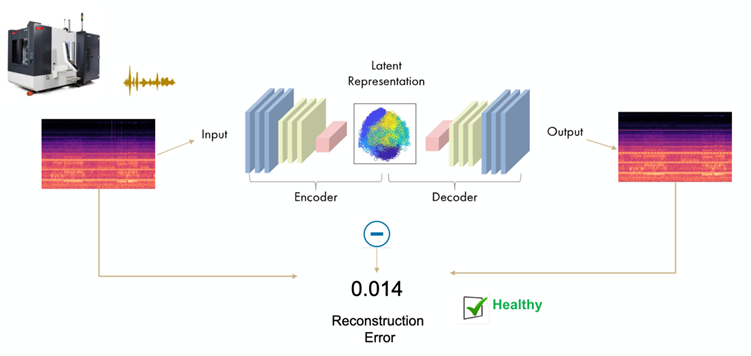

A convolutional autoencoder is different from a traditional autoencoder in the sense that it uses convolutional layers instead of completely linked layers in its architecture. While both aim to learn compact representations of input data, convolutional autoencoders are specifically designed for tasks involving spatially structured data like images (and spectrograms in this case). Convolutional layers capture spatial patterns effectively, making them ideal for image denoising, compression, and reconstruction. Thus, they are ideal in this situation in working with spectrograms of audio files. They are also inherently robust to translations in the input data, thanks to the translation-invariant properties of convolutional operations, while traditional autoencoders may struggle with processing spatial information and require additional techniques to handle spatially structured data effectively.

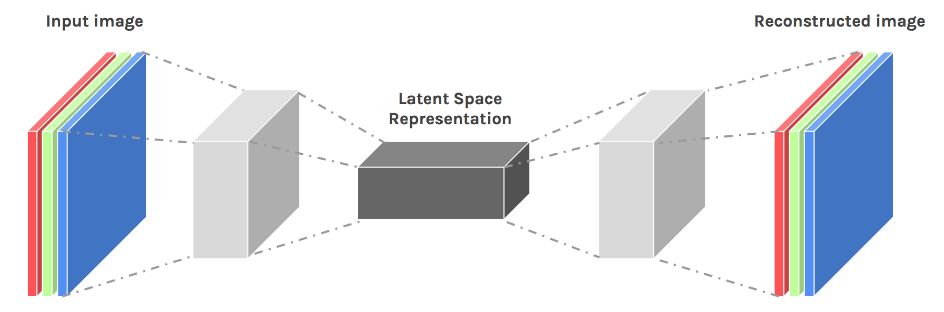

A convolutional autoencoder is created with the Keras library. It learns to compress input data into a lower-dimensional latent space representation and reconstruct the original input data from this representation. Through an MAE loss function and Adap optimizer, its results are refined. The specific portions of the code are described in further detail as follows:

Encoder: This part compresses the input data into a lower-dimensional representation (latent space) by applying convolutional and pooling layers to extract features from the input. A SELU activation function and max-pooling layers (MaxPool2D) are used to reduce the spatial dimensions of the input while increasing the depth (number of channels). The output is then flattened to further reduce the dimensionality before reaching the bottleneck layer.

Latent Space: The bottleneck layer represents the latent space, where the compressed representation of the input data is learned. It has a fully connected layer with SELU activation. LATENT_SPACE_DIMS determines the number of units in this layer.

Decoder: This portion reconstructs the original input data from the compressed representation in the latent space. Fully connected layers with SELU activation are used to upscale the latent representation to a size compatible with the shape before the bottleneck layer. The reshaped data is then passed through transposed layers to slowly increase the spatial dimensions while decreasing depth to generate output.

Model Compilation: The model is compiled using MAE (Mean Absolute Error) to measure the difference between the reconstructed output and the original input. Metrics are set to track the MAE during training. An Adam optimizer is used for optimization. The Adam optimizer adjusts learning rates and performs bias correction to improve stability by tweaking hyperparameters.

In [ ]:
#Necessary Autoencoder Libaries
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

#Create convolusional autoencoder model
input = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

# Encoder
x = keras.layers.Conv2D(8 , kernel_size=(3,3), padding = 'same', activation = 'selu')(input)
x = keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x)
x = keras.layers.Conv2D(16 , kernel_size=(3,3), padding = 'same', activation = 'selu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x)
x = keras.layers.Conv2D(32, kernel_size=(3,3), padding = 'same', activation = 'selu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x)
shape_before_bottleneck = K.int_shape(x)[1:]
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=128, activation = 'selu')(x)

# Bottle neck layer (Latent space)
x = keras.layers.Dense(units= LATENT_SPACE_DIMS , activation = 'selu')(x)

# Decoder
x = keras.layers.Dense(units= 128, activation = 'selu')(x)
num_neurons = np.prod(shape_before_bottleneck)
x = keras.layers.Dense(units=num_neurons , activation = 'selu')(x)
x = keras.layers.Reshape(shape_before_bottleneck)(x)
x = keras.layers.Conv2DTranspose(16, kernel_size=(3,3), padding = 'same', activation = 'selu', strides = 2)(x)
x = keras.layers.Conv2DTranspose(8 , kernel_size=(3,3), padding = 'same', activation = 'selu', strides = 2)(x)
x = keras.layers.Conv2DTranspose(1 , kernel_size=(3,3), padding = 'same', activation = 'selu', strides = 2)(x)

Conv_AE = Model(input, x)

# Metric for optimization: Mean Absolute Error (MAE) = Reconstruction Error
opt = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
Conv_AE.compile(loss="mae", optimizer = opt, metrics=['mae'])
Conv_AE.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1160, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 1160, 8)     80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 512, 580, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 580, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 256, 290, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 290, 32)      4640  

The complex model took around 30 minutes to train and traverse 20 epochs. With every epoch, the MAE and loss both decrease and plateau near the end.

In [ ]:
#Training the Convolutional Autoencoder Model

history = Conv_AE.fit(x_train, x_train, batch_size=BATCH_SIZE, epochs = EPOCHS, shuffle = True)

Epoch 1/20
10/10 [==============================] - 88s 8s/step - loss: 0.2718 - mae: 0.2718
Epoch 2/20
10/10 [==============================] - 87s 9s/step - loss: 0.1638 - mae: 0.1638
Epoch 3/20
10/10 [==============================] - 84s 9s/step - loss: 0.1038 - mae: 0.1038
Epoch 4/20
10/10 [==============================] - 80s 8s/step - loss: 0.0721 - mae: 0.0721
Epoch 5/20
10/10 [==============================] - 77s 8s/step - loss: 0.0599 - mae: 0.0599
Epoch 6/20
10/10 [==============================] - 75s 7s/step - loss: 0.0538 - mae: 0.0538
Epoch 7/20
10/10 [==============================] - 78s 8s/step - loss: 0.0504 - mae: 0.0504
Epoch 8/20
10/10 [==============================] - 75s 8s/step - loss: 0.0485 - mae: 0.0485
Epoch 9/20
10/10 [==============================] - 77s 8s/step - loss: 0.0468 - mae: 0.0468
Epoch 10/20
10/10 [==============================] - 74s 7s/step - loss: 0.0456 - mae: 0.0456
Epoch 11/20
10/10 [==============================] - 86s 9s/step - lo

As seen below, the MAE and reconstruction error experiences exponential decay as epochs increase.

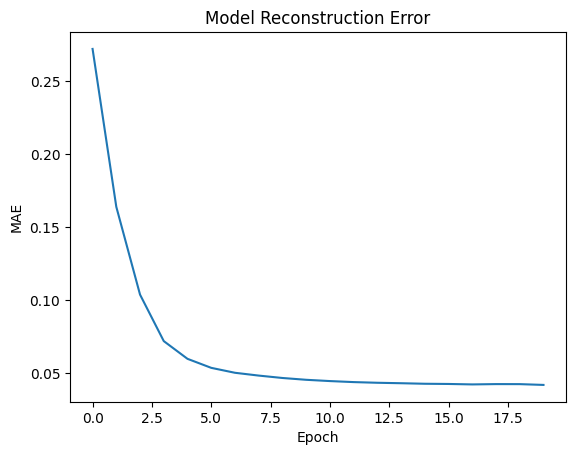

In [ ]:
plt.plot(history.epoch, history.history['mae'], label='Mean Absolute Error (Reconstruction Error)')
plt.title('Model Reconstruction Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.show()

The mode is then saved (specifically the model weights) as a .h5 file. This can then be used to reload the trained model when needed.

In [ ]:
#Saving Model and Weights (if necessary)
folder = './training'
if not os.path.exists(folder):
  os.makedirs(folder)
save_path = os.path.join(folder, "weights.h5")
Conv_AE.save_weights(save_path)

### Creating the Testing Dataset

If model weights have already been obtained, the following code can be uncommented to load the model. This avoids needing to retrain the model as described earlier in the step-by-step procedure.

In [ ]:
'''
from keras.models import load_model
Conv_AE = load_model('weights.h5')

'''

"\nfrom keras.models import load_model\nConv_AE = load_model('weights.h5')\n\n"

This algorithm retrieves 50 different datasets from the database (just as audio data was previously collected fromt he database).

In [ ]:
#Creating Normal Testing Dataset (Normal Data)
audio_file_storage = './original_audio/20220818'
testing_storage = './testing/20220818'

cycle_dataframe = pd.read_csv(cycle_csv)
dataframe_shape = cycle_dataframe.shape

file_array = [None] * dataframe_shape[0]
cntr = 0
for index in cycle_dataframe.index:
    #print(index)
    if index > 100:
      print('Cycle: ' + str(cntr + 1) +  ' of ' + str(dataframe_shape[0]))
      start = cycle_dataframe['StartLocal'][index]
      end = cycle_dataframe['EndLocal'][index]
      print(end)
      retriever = MaijkerCloudRetriever(SENSOR_MAC)
      sound_file_name = retriever.get_datalake_wav_file(start, end)
      print(sound_file_name)
      new_path = testing_storage + '/' + sound_file_name[2:]
      file_array[cntr] = sound_file_name
      os.rename(sound_file_name[2:], new_path)
      cntr = cntr + 1
      print('\n')
    if cntr >= 50:
      break

cycle_dataframe['FileName'] = file_array
save_file = '20220818_warmup_cycle_files_august.csv'
cycle_dataframe.to_csv(save_file, encoding='utf-8')

Cycle: 1 of 1772
8/18/2022 18:57:43
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A57%3A14%2B00%3A00&EndUtc=2022-08-18%2018%3A57%3A43%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Clip and Merge: 4 Audio Files
./c8e0e70f-b04c-45ce-9698-40ddf9ed567c.wav


Cycle: 2 of 1772
8/18/2022 18:58:12
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A57%3A43%2B00%3A00&EndUtc=2022-08-18%2018%3A58%3A12%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Clip and Merge: 4 Audio Files
./a7c35c2d-7282-45d3-bf94-4364d821b0d5.wav


Cycle: 3 of 1772
8/18/2022 18:58:40
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A58%3A12%2B00%3A00&EndUtc=2022-08-18%2018%3A58%3A40%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Clip and Merge: 4 Audio Files
./a4c88e30-1931-43d2-9f12-b272b9d3a47a.wav


Cycle: 4 of 1772
8/18/2022 18:59:09
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A58%3A40%2B00%3A00&EndUtc=2022-08-18%2018%3A59%3A09%2B00%3A00


100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Clip and Merge: 3 Audio Files
./b6b2056d-55c2-40df-abda-bf97ebb435a9.wav


Cycle: 5 of 1772
8/18/2022 18:59:37
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A59%3A09%2B00%3A00&EndUtc=2022-08-18%2018%3A59%3A37%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


Clip and Merge: 3 Audio Files
./ecbceda4-d657-4ec2-9687-34eb46d06448.wav


Cycle: 6 of 1772
8/18/2022 19:00:05
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2018%3A59%3A37%2B00%3A00&EndUtc=2022-08-18%2019%3A00%3A05%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Clip and Merge: 4 Audio Files
./52eb0f47-b1c6-40ef-886a-bb096a9b7d2b.wav


Cycle: 7 of 1772
8/18/2022 19:00:34
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A00%3A05%2B00%3A00&EndUtc=2022-08-18%2019%3A00%3A34%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Clip and Merge: 4 Audio Files
./6454513e-69b4-4781-acb9-0bf01ff2bd0f.wav


Cycle: 8 of 1772
8/18/2022 19:01:02
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A00%3A34%2B00%3A00&EndUtc=2022-08-18%2019%3A01%3A02%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


Clip and Merge: 4 Audio Files
./9d4c5e53-30f4-4fc3-95b6-3478204dd6cb.wav


Cycle: 9 of 1772
8/18/2022 19:01:31
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A01%3A02%2B00%3A00&EndUtc=2022-08-18%2019%3A01%3A31%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Clip and Merge: 3 Audio Files
./ac68c5d0-a648-45fb-9157-9ab63c9d5ebf.wav


Cycle: 10 of 1772
8/18/2022 19:01:59
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A01%3A31%2B00%3A00&EndUtc=2022-08-18%2019%3A01%3A59%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


Clip and Merge: 4 Audio Files
./4e7a4317-b862-4b76-9221-60c83571b281.wav


Cycle: 11 of 1772
8/18/2022 19:02:28
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A01%3A59%2B00%3A00&EndUtc=2022-08-18%2019%3A02%3A28%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Clip and Merge: 4 Audio Files
./7580484e-a406-41e2-b724-33334b4ce8a3.wav


Cycle: 12 of 1772
8/18/2022 19:02:56
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A02%3A28%2B00%3A00&EndUtc=2022-08-18%2019%3A02%3A56%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Clip and Merge: 4 Audio Files
./15183ad3-0d7c-46f7-a31f-6aedac4c0de7.wav


Cycle: 13 of 1772
8/18/2022 19:03:25
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A02%3A56%2B00%3A00&EndUtc=2022-08-18%2019%3A03%3A25%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Clip and Merge: 3 Audio Files
./70a94ac0-39cd-4d66-bc6b-c35a4e9e0a6b.wav


Cycle: 14 of 1772
8/18/2022 19:03:53
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A03%3A25%2B00%3A00&EndUtc=2022-08-18%2019%3A03%3A53%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Clip and Merge: 4 Audio Files
./00dc5e9e-c842-4c3e-bebd-890ebb5a1dd1.wav


Cycle: 15 of 1772
8/18/2022 19:04:21
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A03%3A53%2B00%3A00&EndUtc=2022-08-18%2019%3A04%3A21%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


Clip and Merge: 4 Audio Files
./7bf11c70-9e19-486b-b41c-5e16ee859715.wav


Cycle: 16 of 1772
8/18/2022 19:04:50
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A04%3A21%2B00%3A00&EndUtc=2022-08-18%2019%3A04%3A50%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Clip and Merge: 4 Audio Files
./4b6acbfe-928e-4ab0-97db-ffd756e35a96.wav


Cycle: 17 of 1772
8/18/2022 19:05:18
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A04%3A50%2B00%3A00&EndUtc=2022-08-18%2019%3A05%3A18%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Clip and Merge: 4 Audio Files
./ef9fb29f-02ba-42ea-99ca-b468ff339f54.wav


Cycle: 18 of 1772
8/18/2022 19:05:47
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A05%3A18%2B00%3A00&EndUtc=2022-08-18%2019%3A05%3A47%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


Clip and Merge: 3 Audio Files
./0a52a1fe-3226-4058-8eed-64778e2c1991.wav


Cycle: 19 of 1772
8/18/2022 19:06:15
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A05%3A47%2B00%3A00&EndUtc=2022-08-18%2019%3A06%3A15%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Clip and Merge: 4 Audio Files
./00343abb-f961-41c1-92e5-8c936c8646d3.wav


Cycle: 20 of 1772
8/18/2022 19:06:44
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A06%3A15%2B00%3A00&EndUtc=2022-08-18%2019%3A06%3A44%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Clip and Merge: 4 Audio Files
./6637f6bd-3632-4fda-b7a2-031ad6b045b8.wav


Cycle: 21 of 1772
8/18/2022 19:07:13
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A06%3A44%2B00%3A00&EndUtc=2022-08-18%2019%3A07%3A13%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Clip and Merge: 4 Audio Files
./f511b7af-7947-4574-ad8e-0545a1dfa4ea.wav


Cycle: 22 of 1772
8/18/2022 19:07:40
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A07%3A13%2B00%3A00&EndUtc=2022-08-18%2019%3A07%3A40%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


Clip and Merge: 3 Audio Files
./42621e93-9f84-476d-83ff-40f88896ea1d.wav


Cycle: 23 of 1772
8/18/2022 19:08:09
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A07%3A40%2B00%3A00&EndUtc=2022-08-18%2019%3A08%3A09%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Clip and Merge: 4 Audio Files
./efb5a938-7329-4585-9d98-df614ca39a94.wav


Cycle: 24 of 1772
8/18/2022 19:08:38
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A08%3A09%2B00%3A00&EndUtc=2022-08-18%2019%3A08%3A38%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Clip and Merge: 4 Audio Files
./12aa27be-614f-4542-aa4b-e04307497a2b.wav


Cycle: 25 of 1772
8/18/2022 19:09:06
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A08%3A38%2B00%3A00&EndUtc=2022-08-18%2019%3A09%3A06%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Clip and Merge: 4 Audio Files
./7a409646-e91a-4a6f-bd9b-7a4337cdb0fb.wav


Cycle: 26 of 1772
8/18/2022 19:09:35
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A09%3A06%2B00%3A00&EndUtc=2022-08-18%2019%3A09%3A35%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Clip and Merge: 4 Audio Files
./01207713-fd3d-434c-b44e-7843d1cb9da3.wav


Cycle: 27 of 1772
8/18/2022 19:10:03
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A09%3A35%2B00%3A00&EndUtc=2022-08-18%2019%3A10%3A03%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Clip and Merge: 3 Audio Files
./8d36f508-23a5-43e6-a55b-bea5ae5510f9.wav


Cycle: 28 of 1772
8/18/2022 19:10:31
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A10%3A03%2B00%3A00&EndUtc=2022-08-18%2019%3A10%3A31%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Clip and Merge: 4 Audio Files
./c55acf52-9060-4b16-b368-fad881f38857.wav


Cycle: 29 of 1772
8/18/2022 19:11:00
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A10%3A31%2B00%3A00&EndUtc=2022-08-18%2019%3A11%3A00%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Clip and Merge: 4 Audio Files
./d37043f7-0955-4980-b3ff-29aa56e73a18.wav


Cycle: 30 of 1772
8/18/2022 19:11:28
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A11%3A00%2B00%3A00&EndUtc=2022-08-18%2019%3A11%3A28%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Clip and Merge: 4 Audio Files
./4497ab2b-c4d5-4355-9f8a-ba8a02d2da79.wav


Cycle: 31 of 1772
8/18/2022 19:11:57
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A11%3A28%2B00%3A00&EndUtc=2022-08-18%2019%3A11%3A57%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Clip and Merge: 3 Audio Files
./61a0b609-5ba3-4dd2-922a-a4a2d7082c2f.wav


Cycle: 32 of 1772
8/18/2022 19:12:25
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A11%3A57%2B00%3A00&EndUtc=2022-08-18%2019%3A12%3A25%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Clip and Merge: 4 Audio Files
./71e13551-56d4-4c76-b709-60b2cbee0c17.wav


Cycle: 33 of 1772
8/18/2022 19:12:54
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A12%3A25%2B00%3A00&EndUtc=2022-08-18%2019%3A12%3A54%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Clip and Merge: 4 Audio Files
./034f7af8-ab78-4460-aadb-2de80e411500.wav


Cycle: 34 of 1772
8/18/2022 19:13:22
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A12%3A54%2B00%3A00&EndUtc=2022-08-18%2019%3A13%3A22%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Clip and Merge: 4 Audio Files
./a1ebb00c-9d29-4b2d-9125-c7338b8257de.wav


Cycle: 35 of 1772
8/18/2022 19:13:51
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A13%3A22%2B00%3A00&EndUtc=2022-08-18%2019%3A13%3A51%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Clip and Merge: 4 Audio Files
./c05ff21f-b03a-4ade-b32c-be9fd74092a0.wav


Cycle: 36 of 1772
8/18/2022 19:14:19
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A13%3A51%2B00%3A00&EndUtc=2022-08-18%2019%3A14%3A19%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Clip and Merge: 3 Audio Files
./cefd41e9-5f67-47a1-8197-28184554ec2b.wav


Cycle: 37 of 1772
8/18/2022 19:14:47
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A14%3A19%2B00%3A00&EndUtc=2022-08-18%2019%3A14%3A47%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Clip and Merge: 4 Audio Files
./556ea491-a667-4eb7-a9aa-cc8d7cd41786.wav


Cycle: 38 of 1772
8/18/2022 19:15:16
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A14%3A47%2B00%3A00&EndUtc=2022-08-18%2019%3A15%3A16%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Clip and Merge: 4 Audio Files
./67683f17-91f2-4c63-b510-b786d4d14c42.wav


Cycle: 39 of 1772
8/18/2022 19:15:45
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A15%3A16%2B00%3A00&EndUtc=2022-08-18%2019%3A15%3A45%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Clip and Merge: 4 Audio Files
./cf4df8c5-22e8-44fa-94f2-01d7032fc001.wav


Cycle: 40 of 1772
8/18/2022 19:16:13
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A15%3A45%2B00%3A00&EndUtc=2022-08-18%2019%3A16%3A13%2B00%3A00


100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Clip and Merge: 3 Audio Files
./aee1ed05-5d59-49f3-a5b0-00ffb24541b2.wav


Cycle: 41 of 1772
8/18/2022 19:16:41
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A16%3A13%2B00%3A00&EndUtc=2022-08-18%2019%3A16%3A41%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Clip and Merge: 4 Audio Files
./7087bd17-f8a8-4988-852c-5e0cc93cd464.wav


Cycle: 42 of 1772
8/18/2022 19:17:10
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A16%3A41%2B00%3A00&EndUtc=2022-08-18%2019%3A17%3A10%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


Clip and Merge: 4 Audio Files
./2f00d171-6e63-4713-8286-fdb930054311.wav


Cycle: 43 of 1772
8/18/2022 19:17:38
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A17%3A10%2B00%3A00&EndUtc=2022-08-18%2019%3A17%3A38%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Clip and Merge: 4 Audio Files
./0a4a765e-cda4-4bff-8ca5-5fb65e42b462.wav


Cycle: 44 of 1772
8/18/2022 19:18:07
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A17%3A38%2B00%3A00&EndUtc=2022-08-18%2019%3A18%3A07%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


Clip and Merge: 4 Audio Files
./dc95e308-e562-4a67-99d1-72f27be0f202.wav


Cycle: 45 of 1772
8/18/2022 19:18:35
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A18%3A07%2B00%3A00&EndUtc=2022-08-18%2019%3A18%3A35%2B00%3A00


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Clip and Merge: 3 Audio Files
./ef8bffe3-d336-470a-8382-ee0508960a20.wav


Cycle: 46 of 1772
8/18/2022 19:19:04
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A18%3A35%2B00%3A00&EndUtc=2022-08-18%2019%3A19%3A04%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Clip and Merge: 4 Audio Files
./e29a8de7-d8fc-4e57-ad93-4637180ecdfd.wav


Cycle: 47 of 1772
8/18/2022 19:19:32
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A19%3A04%2B00%3A00&EndUtc=2022-08-18%2019%3A19%3A32%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Clip and Merge: 4 Audio Files
./206d1989-7d3d-41d9-a4f3-7adb40e6cf4d.wav


Cycle: 48 of 1772
8/18/2022 19:20:00
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A19%3A32%2B00%3A00&EndUtc=2022-08-18%2019%3A20%3A00%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Clip and Merge: 4 Audio Files
./9e17c931-ba0f-4338-9e02-4a438ecaf6db.wav


Cycle: 49 of 1772
8/18/2022 19:20:29
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A20%3A00%2B00%3A00&EndUtc=2022-08-18%2019%3A20%3A29%2B00%3A00


100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


Clip and Merge: 3 Audio Files
./7c6d0f78-89c9-4579-a11a-004c5014d391.wav


Cycle: 50 of 1772
8/18/2022 19:20:58
E4:5F:01:78:5E:7F
initializing cloud api
success creating service_client
https://maijker-cloud.azurewebsites.net/api/SoundFiles?SensorUuid=6e709d91-ab10-45c1-a5b0-b31cd90e0048&StartUtc=2022-08-18%2019%3A20%3A29%2B00%3A00&EndUtc=2022-08-18%2019%3A20%3A58%2B00%3A00


100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

Clip and Merge: 4 Audio Files
./af1b7e25-98b0-48ef-91df-ae7780c4823f.wav




A "Store" function is recreated to accept an additional parameter: the dictionary.

In [ ]:
#Helper Function to Store Values
def store_min_max_values(dictionary, save_path, min_val, max_val):
  dictionary[save_path] = {
      "min": min_val,
      "max": max_val
  }

This algorithm mimics that of the preprocessing pipeline used for the training dataset. Here, the original audio signals are retrieved as an array to compare them against the reconstructed output later.

In [ ]:
#Preprocessing Testing Dataset (Normal Data)
postprocessing_storage = './postprocessing/20220818'
testing_storage = './testing/20220818'

FRAME_SIZE = 2048
HOP_LENGTH = int(FRAME_SIZE / 4)
NUM_SAMPLES = 593500
min_max_values_testing = {}
original_signals = []

for root, _, files in os.walk(testing_storage):
  for audio_file in files:
    #Loading the file
    file_path = os.path.join(root, audio_file)
    signal = librosa.load(file_path)[0]
    signal = signal[:NUM_SAMPLES]
    original_signals.append(signal)
    sample_rate = librosa.get_samplerate(file_path)
    duration = librosa.get_duration(y= signal, sr = sample_rate)

    #Padding the signal if necessary
    padding = padding_bool(signal, sample_rate, duration)
    if padding == True:
      num_expected_samples = int(sample_rate * duration)
      num_missing_samples = num_expected_samples - len(signal)
      padded_signal = right_pad(signal, num_missing_samples)
      signal = padded_signal


    #Extracting the log spectrogram from the audio file
    stft = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_LENGTH)[:-1]
    #print(stft.shape)
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    feature = log_spectrogram
    norm_feature = normalize(feature,0,1)

    #Saving the feature
    file_name = os.path.split(file_path)[1]
    save_path = os.path.join(postprocessing_storage, file_name[:-4] + ".npy")
    np.save(save_path, norm_feature)

    #Store min and max values in the dictionary
    store_min_max_values(min_max_values_testing, save_path, feature.min(), feature.max())
    print(f'Processing File: {file_name}')

min_max_storage_testing = './postprocessing'
#print(original_signals)
#print(min_max_values_testing)
save_min_max_values(min_max_values_testing, min_max_storage_testing)

Processing File: ac68c5d0-a648-45fb-9157-9ab63c9d5ebf.wav
Processing File: a1ebb00c-9d29-4b2d-9125-c7338b8257de.wav
Processing File: 6637f6bd-3632-4fda-b7a2-031ad6b045b8.wav
Processing File: 01207713-fd3d-434c-b44e-7843d1cb9da3.wav
Processing File: ef9fb29f-02ba-42ea-99ca-b468ff339f54.wav
Processing File: 7580484e-a406-41e2-b724-33334b4ce8a3.wav
Processing File: 52eb0f47-b1c6-40ef-886a-bb096a9b7d2b.wav
Processing File: 0a52a1fe-3226-4058-8eed-64778e2c1991.wav
Processing File: 71e13551-56d4-4c76-b709-60b2cbee0c17.wav
Processing File: 42621e93-9f84-476d-83ff-40f88896ea1d.wav
Processing File: 7087bd17-f8a8-4988-852c-5e0cc93cd464.wav
Processing File: 8d36f508-23a5-43e6-a55b-bea5ae5510f9.wav
Processing File: 67683f17-91f2-4c63-b510-b786d4d14c42.wav
Processing File: 206d1989-7d3d-41d9-a4f3-7adb40e6cf4d.wav
Processing File: cf4df8c5-22e8-44fa-94f2-01d7032fc001.wav
Processing File: 7bf11c70-9e19-486b-b41c-5e16ee859715.wav
Processing File: 00dc5e9e-c842-4c3e-bebd-890ebb5a1dd1.wav
Processing Fil

This mimics the algorithm from the training dataset. In addition, the file paths are also stored.

In [ ]:
#Creating the Testing Dataset

x_test = []
file_paths = []
for root, _, file_names in os.walk(postprocessing_storage):
    for file_name in file_names:
        file_path = os.path.join(root, file_name)
        spectrogram = np.load(file_path) # (n_bins, n_frames)
        #print(spectrogram.shape)
        x_test.append(spectrogram)
        file_paths.append(file_path)
x_test = np.array(x_test)
x_test = x_test[..., np.newaxis] # -> (n_files, n_bins, n_frames, 1)
x_test.shape

(50, 1024, 1160, 1)

### Conversion from Log Spectrograms to Time Series Audio Data

To convert from a Log Spectrogram to a Time Series Audio Data involves reshaping the spectrogtram to its original format before normalization for compatibility. If normalized, it must be denormalized to restore its original scale. Next, the log spectrogram is transformed back to a linear scale by exponentiating the values (to undo the logarithmic transformation).
Next, the Griffin-Lim algorithm is applied to reconstruct the audio signal from the spectrogram representation, iteratively refining the time signal output. The final reconstructed time-series audio data is then appended to a collection named "signals,". This consolidates all the audio files into their original time-series format to make future processing or analysis easier.

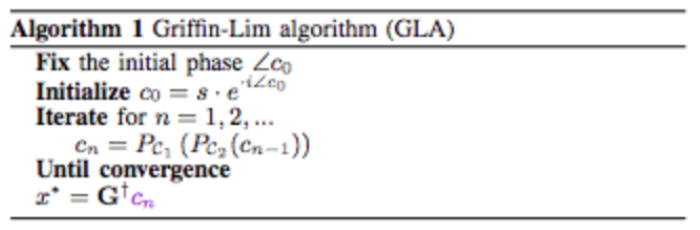

The Griffin-Lim transformation is a method for reconstructing audio waveforms from their corresponding magnitude spectrograms. It involves iteratively estimating the phase information of the signal from its magnitude spectrogram, allowing for the reconstruction of the original audio waveform. This process starts with an initial estimate of the waveform, such as white noise or the magnitude spectrogram itself, and then iteratively refines the estimate by replacing the phase information of the spectrogram with that of the original signal and performing inverse short-time Fourier transforms. This iterative process continues until convergence criteria are met, such as reaching a maximum number of iterations or a small change in the reconstructed waveform between iterations. Once convergence is achieved, the final estimate of the audio waveform is obtained, enabling the conversion of spectrograms into audio data WAV files.

We utilized the Griffin-Lim reconstruction method over the inverse STFT function as it provided a reconstructed output that was a lot closer to the original audio than the inverse STFT did, as seen in the image below.


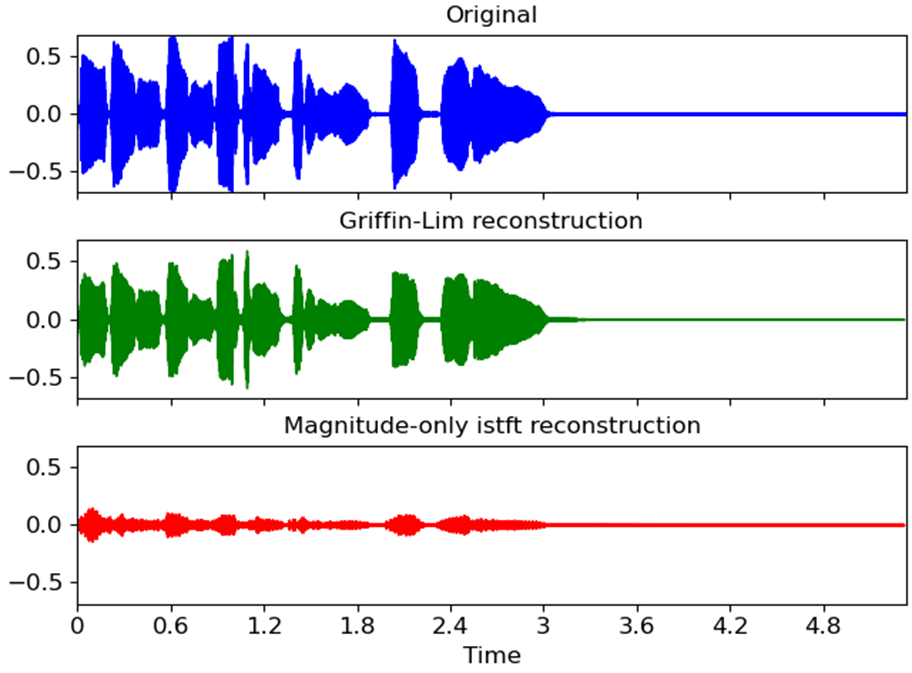

The fast griffin lim generator function was gathered from this GitHub repository: https://github.com/rbarghou/pygriffinlim



In [ ]:
#Helper Functions for Reconstructing Log Spectrogram to a .wav file

def fast_griffin_lim_generator(
        spectrogram,
        iterations=10,
        approximated_signal=None,
        alpha=.1,
        stft_kwargs={"n_fft": FRAME_SIZE,
            "hop_length": HOP_LENGTH},
        istft_kwargs={"hop_length": HOP_LENGTH}):
    """

    :param spectrogram:
    :param iterations:
    :param approximated_signal:
    :param alpha:
    :param stft_kwargs:
    :param istft_kwargs:
    :return:
    """
    _M = spectrogram
    for k in range(iterations):
        if approximated_signal is None:
            _P = np.random.randn(*_M.shape)
        else:
            _D = librosa.stft(approximated_signal, **stft_kwargs)[:-1]
            _P = np.angle(_D)

        _D = _M * np.exp(1j * _P)
        _M = spectrogram + (alpha * np.abs(_D))
        approximated_signal = librosa.istft(_D, **istft_kwargs)
        yield approximated_signal

def generate(spectrograms, min_max_values):
    generated_spectrograms = Conv_AE.predict(spectrograms)

    signals = []
    for spectrogram, min_max_value in zip(generated_spectrograms, min_max_values):
        # reshape the log spectrogram
        log_spectrogram = spectrogram[:, :, 0]
        # apply denormalisation
        denorm_spectrogram = denormalize(log_spectrogram, 0, 1, min_max_value["min"], min_max_value["max"])
        # log spectrogram -> spectrogram
        spec = librosa.db_to_amplitude(denorm_spectrogram)
        # apply Griffin-Lim
        generator = fast_griffin_lim_generator(spec)
        for approximated_signal in generator:
            pass
        # append signal to "signals"
        signals.append(approximated_signal)
    return signals



In order to convert the log spectrogram into an audio file and save it to a directory, we had to gather the min max values from the dataset to help denormalize the dataset into its normal parameters. Then the generate function is used to convert the signal to a WAV file and the soundfile library is used to save the reconstructed audio files to a directory.

In [ ]:
#Creating Reconstructed Log Spectrogram and Converting it into and Audio File
import soundfile as sf

file_paths_nm = []

# load spectrograms + min max values
with open('./postprocessing/min_max_values.pkl', "rb") as f:
    min_max_values = pickle.load(f)

#Gathering min_max values from testing dataset
sampled_min_max_values = [min_max_values_testing[file_path] for file_path in file_paths]

#Generating audio wav files from log spectrogram
signals = generate(x_test, sampled_min_max_values)

#Saving the audio files in the reconstructed audio folder
for i, signal in enumerate(signals):
    save_path = os.path.join('./reconstructed_audio_gl/20220818', str(i) + ".wav")
    file_paths_nm.append(save_path)
    sf.write(save_path, signal, sample_rate)

2/2 [==============================] - 15s 5s/step


### Original Audio vs Reconstructed Audio

Here we can see a comparison between the original audio and the reconstructed audio.

Text(0.5, 0.98, 'Comparison of Original to Reconstructed Input')

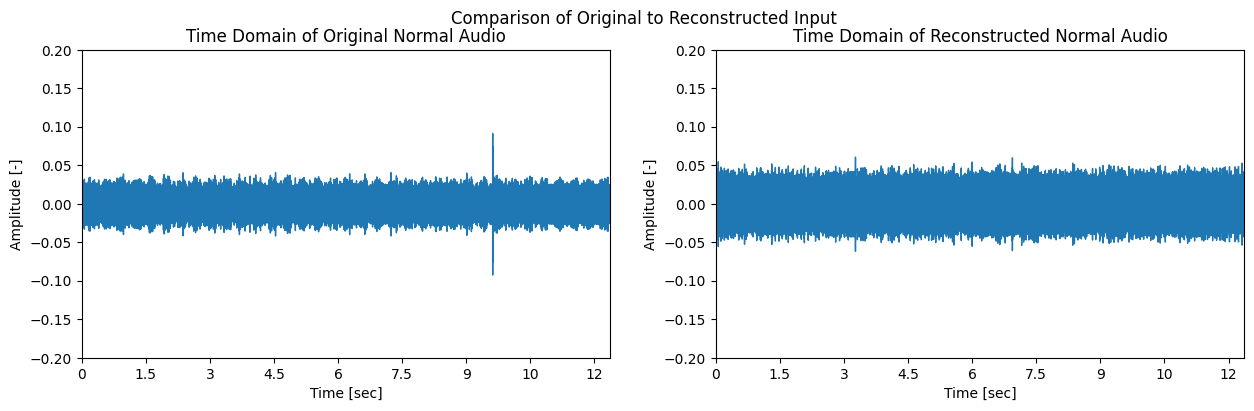

In [ ]:
#Visual Representation of the Original vs. Reconstructed Audio

# Randomly select a data sample
datanum = np.random.randint(0,x_test.shape[0]-1)
#print(datanum)

original = original_signals[datanum]
restored = signals[datanum]


fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
librosa.display.waveshow(original, sr=sample_rate, ax=ax[0]) # time domain (raw data) plot
librosa.display.waveshow(restored, sr=sample_rate, ax=ax[1]) # time domain (raw data) plot
ax[0].set(title="Time Domain of Original Normal Audio", ylim=[-0.2, 0.2], xlim=[0, duration], ylabel="Amplitude [-]", xlabel="Time [sec]")
ax[1].set(title="Time Domain of Reconstructed Normal Audio", ylim=[-0.2, 0.2], xlim=[0, duration], ylabel="Amplitude [-]", xlabel="Time [sec]")
fig.suptitle("Comparison of Original to Reconstructed Input")

### Normal Data vs Abnormal Data

Creation of the abnormal dataset using artificial noise by leveraging Guassian noise.

In [ ]:
#Creating Abnormal Dataset - Same size as the Testing Data
import math

abnormal_storage = './abnormal_data/20220818'
reconstructed_audio_gl_storage = './reconstructed_audio_gl/20220818'

abnormal_signals = []
file_paths_ab = []
cntr = 0
for root, _, file_names in os.walk(reconstructed_audio_gl_storage):
    for file_name in file_names:
        file_path = os.path.join(root, file_name)
        signal, sr = librosa.load(file_path, sr = 48000)
        RMS = math.sqrt(np.mean(signal**2))
        STD_n= 0.02
        noise = np.random.normal(0, STD_n, signal.shape[0])
        signal_noise = signal + noise
        save_path = os.path.join('./abnormal_data/20220818', str(cntr) + "_ab" + ".wav")
        abnormal_signals.append(signal_noise)
        file_paths_ab.append(save_path)
        cntr += 1

        sf.write(save_path, signal_noise, sr)

To simulate abnormal data, noise was added. Evidently, the frequency and magnitude is larger for abnormal data.

Text(0.5, 0.98, 'Comparison of Normal to Abnormal Audio Data')

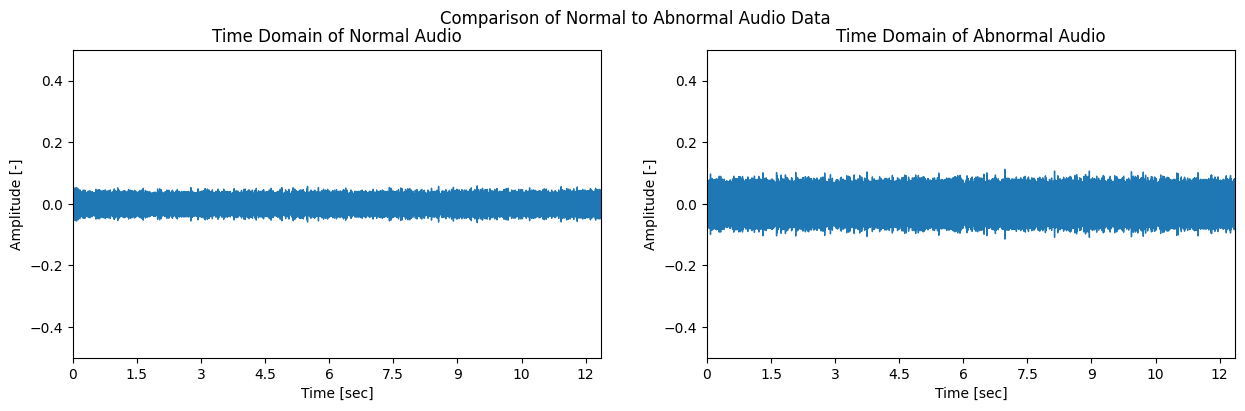

In [ ]:
#Visualizing Normal vs Abnormal Dataset (Time Domain)

# Randomly select a data sample
datanum = np.random.randint(0,x_test.shape[0]-1)
#print(datanum)

original = signals[datanum]
abnormal = abnormal_signals[datanum]


fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
librosa.display.waveshow(original, sr=sample_rate, ax=ax[0]) # time domain (raw data) plot
librosa.display.waveshow(abnormal, sr=sample_rate, ax=ax[1]) # time domain (raw data) plot
ax[0].set(title="Time Domain of Normal Audio", ylim=[-0.5, 0.5], xlim=[0, duration], ylabel="Amplitude [-]", xlabel="Time [sec]")
ax[1].set(title="Time Domain of Abnormal Audio", ylim=[-0.5, 0.5], xlim=[0, duration], ylabel="Amplitude [-]", xlabel="Time [sec]")
fig.suptitle("Comparison of Normal to Abnormal Audio Data")

### Thresholding and Evaluation of the Autoencoder Model

In anomaly detection for machine learning, thresholding is a fundamental technique used to distinguish normal data from anomalies. The process involves setting a threshold value, above or below which data points are considered anomalous. Typically, this threshold is determined based on statistical properties of the data, such as mean and standard deviation, or through more sophisticated methods like clustering or density estimation. During training, the algorithm learns the normal behavior of the system or dataset. Once trained, during inference or testing, the algorithm compares new data points to the learned normal behavior. Data points that deviate significantly from the norm, surpassing the predefined threshold, are flagged as anomalies. Thresholding provides a simple and effective way to identify outliers or abnormalities in data, making it a widely used approach in various fields such as cybersecurity, finance, and industrial monitoring.

Here we calculate the mean absolute error for every single datapoint, both normal and abnormal. We are going to use this to graph both datasets and identify the threshold.

In [ ]:
#Calculating Mean Absolute Error (MAE), or Recontruction Error of Both Datasets
from sklearn.metrics import mean_absolute_error as mae

normal_mae = []
abnormal_mae = []

for i, signal in enumerate(signals):
  original_signals[i] = original_signals[i][:593408]
  error = mae(original_signals[i], signals[i])
  normal_mae.append(error)

for i, signal in enumerate(abnormal_signals):
  original_signals[i] = original_signals[i][:593408]
  error = mae(original_signals[i], abnormal_signals[i])
  abnormal_mae.append(error)

This is the visual representation of the MAE of both the normal and abnormal dataset. Notice how the abnormal dataset MAE is higher due to the Gaussian noise.

Text(0.5, 0.98, 'Comparison of Normal to Abnormal Reconstruction Errors')

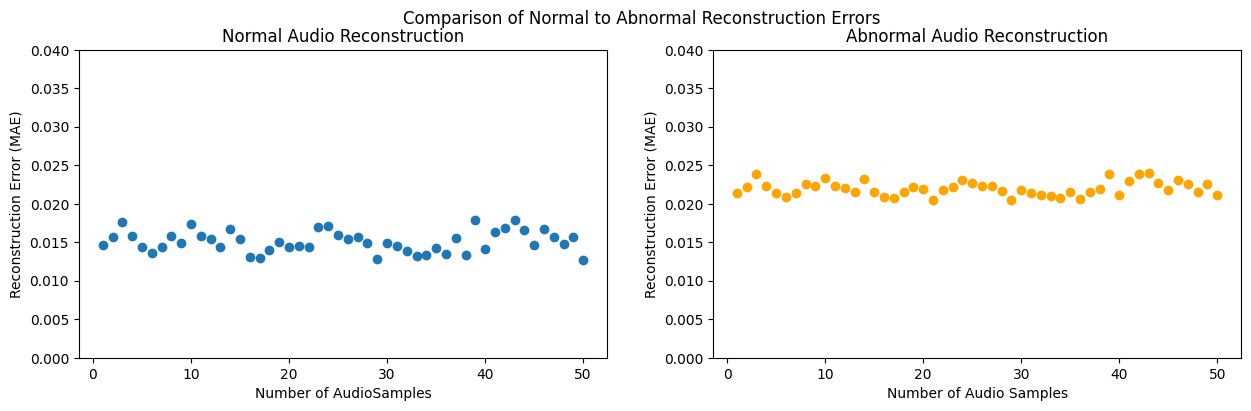

In [ ]:
#Visual Representation of Normal vs. Abnormal Data based on MAE
fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
x = [i for i in range(1, 51)]
ax[0].scatter(x, normal_mae)
ax[1].scatter(x, abnormal_mae, color = 'orange')
ax[0].set(title="Normal Audio Reconstruction", ylim=[0, 0.04], ylabel="Reconstruction Error (MAE)", xlabel="Number of AudioSamples")
ax[1].set(title="Abnormal Audio Reconstruction", ylim=[0, 0.04], ylabel="Reconstruction Error (MAE)", xlabel="Number of Audio Samples")
fig.suptitle("Comparison of Normal to Abnormal Reconstruction Errors")

We determined the threshold using the maximunm line of the normal datasets.

Text(0.5, 0.98, 'Comparison of Normal to Abnormal Reconstruction Errors')

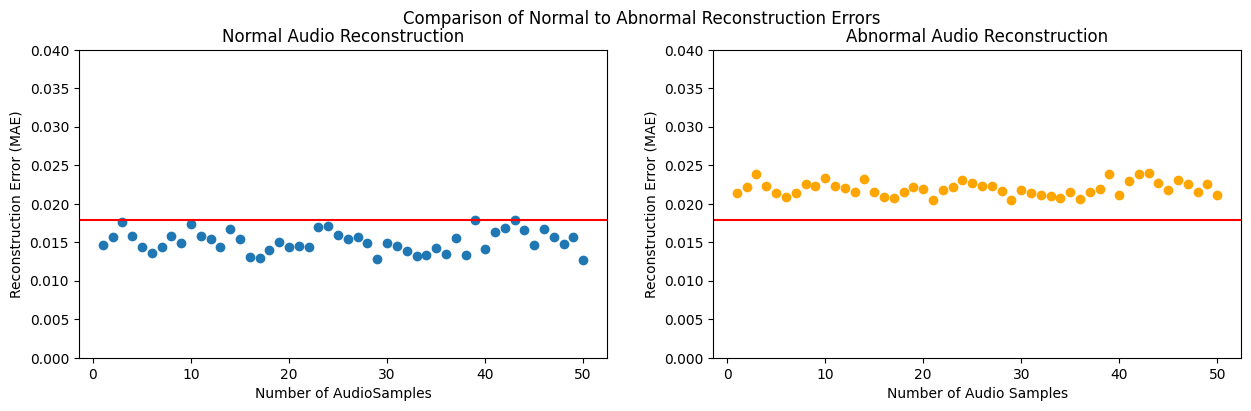

In [ ]:
#Visual Representation of Normal vs. Abnormal Data based on MAE
fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
x = [i for i in range(1, 51)]

maximum = max(normal_mae)
threshold = maximum + 0.0001
#print(max(normal_mae) + 0.001)
ax[0].scatter(x, normal_mae)
ax[1].scatter(x, abnormal_mae, color = 'orange')
ax[0].axhline(y = threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = threshold, color = 'r', linestyle = '-')
ax[0].set(title="Normal Audio Reconstruction", ylim=[0, 0.04], ylabel="Reconstruction Error (MAE)", xlabel="Number of AudioSamples")
ax[1].set(title="Abnormal Audio Reconstruction", ylim=[0, 0.04], ylabel="Reconstruction Error (MAE)", xlabel="Number of Audio Samples")
fig.suptitle("Comparison of Normal to Abnormal Reconstruction Errors")

In [ ]:
#Threshold Value

print(threshold)

0.01793775077214067


The results are imported to a .CSV file.

In [ ]:
#Store File name and whether it is normal or abnormal into a csv file
import csv

mae_csv = normal_mae + abnormal_mae
print(mae_csv)
file_paths_csv = file_paths_nm + file_paths_ab

# Open a CSV file in write mode
with open("predictions.csv", "w", newline="") as csvfile:
    # Create a CSV writer object
    csvwriter = csv.writer(csvfile)

    # Write the header row
    csvwriter.writerow(["File Name", "Prediction"])

    # Iterate over filenames
    cntr = 0
    for filename in file_paths_csv:
        prediction = ''
        if mae_csv[cntr] < threshold:
          prediction = 'Normal'
        else:
          prediction = 'Abnormal'

        # Write the filename and prediction to the CSV file
        csvwriter.writerow([filename, prediction])
        cntr += 1

print("CSV file 'predictions.csv' created successfully.")

[0.014654127038201565, 0.015704411740690895, 0.017631335883919845, 0.01585376585945059, 0.014433070048294203, 0.013632303192450084, 0.014419360703505808, 0.0158695778767001, 0.014931808386447212, 0.01742119935422815, 0.01583046746165281, 0.01546573108034214, 0.014339549206751246, 0.016743484060344045, 0.015418731643371205, 0.013055055745813367, 0.012968550860224814, 0.013931396111213365, 0.015028075394029054, 0.014432236200698197, 0.014444807714392065, 0.01443485152919038, 0.01699633090009831, 0.017170348032801264, 0.01596433176447322, 0.015420189629958487, 0.01573488574159207, 0.01492762272637129, 0.012820322367385721, 0.014943047216482453, 0.014449651453633364, 0.013889005402130186, 0.013165553689267369, 0.013299475973734612, 0.014311560869447763, 0.013517285520072175, 0.015505012273643537, 0.013376920790388833, 0.017821561786660653, 0.014085797435282273, 0.016355704825183625, 0.01686997764253895, 0.01783775077214067, 0.0165844265525427, 0.014602348272306349, 0.01672357907951139, 0.0

### Overall Functionality of the Solution

The overall solution involved gathering sound data from the Maijker cloud, developing a preprocessor, extracting the log spectrogram from the data, loading a model and leveraging a model predict function with model weights to investigate both normal and abnormal data, and using a Griffin Lim feature to convert to a reconstructed audio. MAE is then used to compare the original audio against the reconstructed audio. The error is checked against a threshold to determine if the results are normal or abnormal.

### Benefits of the Solution

Completing this project brings a multitude of benefits to the companies involved, ranging from improved operational efficiency to enhanced competitiveness in the manufacturing landscape. Firstly, the implementation of proactive maintenance strategies through the AI-based monitoring system enables both Starrag and TAMS to anticipate maintenance needs before they escalate into critical issues, ensuring optimal machine performance and longevity. By preemptively troubleshooting potential malfunctions, the project equips maintenance teams with the tools and insights needed to address emerging issues swiftly, minimizing downtime and production disruptions. This reduction in downtime not only improves overall productivity but also mitigates the associated costs of unscheduled maintenance and lost production time. Moreover, the detailed feedback provided by the monitoring system offers valuable insights into machine operation and performance, empowering companies to make data-driven decisions for optimization and process refinement. Continuous monitoring facilitated by the system ensures adaptability to evolving operational conditions, leading to optimized performance and sustained competitiveness in the dynamic manufacturing landscape. Overall, completing this project marks a significant step towards operational excellence and innovation for both Starrag and TAMS, solidifying their positions as leaders in the field of smart manufacturing and industrial IoT integration.

### Key Takeaways and Future Steps

Due to the lack of data and interaction with the actual Bumotec machine, our framework is being developed for the LX21. Thus, implementation of this solution towards the Bumotec would not be ideal and would require additional changes. If those changes become successful, it would be very beneficial to expand and make the framework scalable such that the model can be incorporated for any machine that produces testable sounds. Thus, the missing steps simply include deeper testing for scalability and increased development towards tuning the autoencoder model. Furthermore, true anomaly data would be needed to truly optimize the model and its thresholds to accurately detect irregularities in machine function. Currently, the model is only trained on artificial noise.